<a href="https://colab.research.google.com/github/cjer/covid/blob/master/israel_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
niv = pd.read_csv('https://github.com/cjer/covid/raw/master/data/corona_tested_individuals_ver_0023.csv.gz', encoding='utf-8-sig', low_memory=False, na_values=['None'])
niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-06-14,0,0,0,0,0,שלילי,NaN,נקבה,Other
1,2020-06-14,0,0,0,0,0,שלילי,NaN,נקבה,Other
2,2020-06-14,0,0,0,0,0,שלילי,NaN,נקבה,Other
3,2020-06-14,0,0,0,0,0,שלילי,NaN,נקבה,Other
4,2020-06-14,0,0,0,0,0,שלילי,NaN,נקבה,Other


In [ ]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [ ]:
bdi = pd.read_csv('https://github.com/cjer/covid/raw/master/data/corona_lab_tests_ver_0022.csv.gz', encoding='utf-8')
try:
  bdi['test_date'] = bdi.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
  bdi['result_date'] = bdi.result_date.apply(pd.to_datetime, format='%Y-%m-%d')
except ValueError:
  bdi['test_date'] = bdi.test_date.apply(pd.to_datetime, format='%m/%d/%Y')
  bdi['result_date'] = bdi.result_date.apply(pd.to_datetime, format='%m/%d/%Y')
except ValueError:
  bdi['test_date'] = bdi.test_date.apply(pd.to_datetime, format='%d/%m/%Y')
  bdi['result_date'] = bdi.result_date.apply(pd.to_datetime, format='%d/%m/%Y')
bdi.head()

,test_date,result_date,corona_result,lab_id,is_first_Test
0,NaT,2020-03-11,שלילי,2,Yes
1,NaT,2020-03-11,שלילי,2,Yes
2,NaT,2020-03-11,שלילי,2,Yes
3,NaT,2020-03-11,שלילי,2,Yes
4,NaT,2020-03-11,שלילי,2,Yes


In [ ]:
bdi.corona_result.value_counts()

שלילי               763955
חיובי                41157
לא בוצע/פסול 999      9872
חיובי גבולי           1743
בעבודה                 596
לא ודאי                396
Name: corona_result, dtype: int64

In [ ]:
niv.corona_result.value_counts()

שלילי    533273
חיובי     17483
אחר        6646
Name: corona_result, dtype: int64

In [ ]:
niv.test_indication.value_counts()

Other                     517524
Abroad                     27085
Contact with confirmed     12793
Name: test_indication, dtype: int64

In [ ]:
niv.age_60_and_above.value_counts()

No     124327
Yes     28006
Name: age_60_and_above, dtype: int64

In [ ]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [ ]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [ ]:
bdi['corona_result'] = bdi.corona_result.map(result_map)

In [ ]:
rec = pd.read_csv('https://github.com/cjer/covid/raw/master/data/corona_recovered_ver_0021.csv.gz', encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,19,9,40-49,זכר,Abroad
1,22,9,30-39,זכר,Contact with confirmed
2,26,9,30-39,זכר,Contact with confirmed
3,28,9,30-39,נקבה,Abroad
4,23,9,20-29,נקבה,Contact with confirmed


In [ ]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

,total_tests_count,size,min,max,mean,median,test_sum
0,2,7,1,15,6.857143,6,14
1,3,7039,2,76,15.969882,16,21117
2,4,2949,2,98,20.365209,20,11796
3,5,2109,4,76,24.007112,24,10545
4,6,1341,6,69,27.171514,27,8046
5,7,862,8,63,30.284223,30,6034
6,8,513,3,68,32.941520,33,4104
7,9,311,2,64,35.427653,35,2799
8,10,519,5,78,40.389210,40,5190


In [ ]:
iso = pd.read_csv('https://github.com/cjer/covid/raw/master/data/corona_isolation_per_day_ver_0022.csv.gz',
                  encoding='utf-8-sig', low_memory=False)
iso.head()

,date\tisolated_today_contact_with_confirmed\tisolated_today_abroad\tnew_contact_with_confirmed\tnew_from_abroad
0,6/17/2020\t11252\t9128\t1421\t463
1,6/16/2020\t11344\t9261\t1463\t593
2,6/15/2020\t11574\t8996\t1242\t889
3,6/14/2020\t11661\t8613\t1763\t634
4,6/13/2020\t10289\t8218\t1005\t438


In [ ]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int64
no_symp                          bool
dtype: object

In [ ]:
niv.age_60_and_above.value_counts()

No     124327
Yes     28006
Name: age_60_and_above, dtype: int64

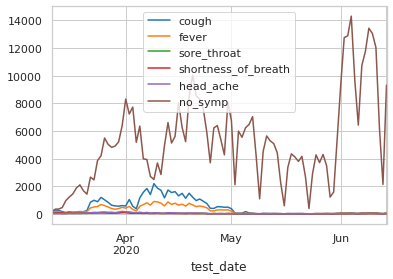

In [ ]:
niv.groupby('test_date')[symptom_cols].sum().plot()

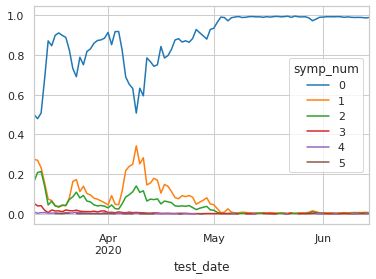

In [ ]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

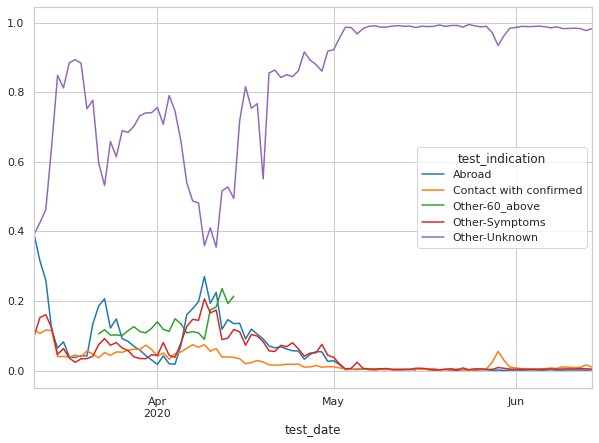

In [ ]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

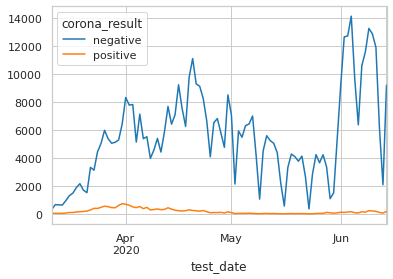

In [ ]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [ ]:
bdi.dtypes

test_date        datetime64[ns]
result_date      datetime64[ns]
corona_result            object
lab_id                    int64
is_first_Test            object
dtype: object

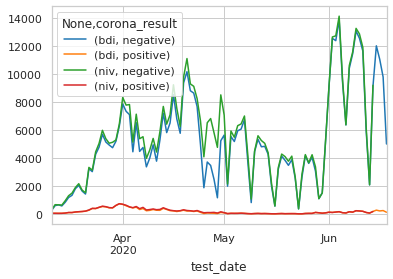

In [ ]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

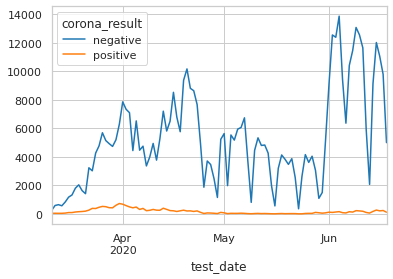

In [ ]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [ ]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='No')].groupby(['test_date', 'corona_result']).size().unstack()

corona_result,negative,positive
test_date,,
2020-03-11,2,3
2020-03-12,19,6
2020-03-13,17,2
2020-03-14,23,1
2020-03-15,68,45
...,...,...
2020-06-14,2776,136
2020-06-15,4210,144
2020-06-16,4411,130


In [ ]:
pone = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'corona_result']).size().unstack()
pone[pone.positive<20]

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-05-02,22.0,NaN,1982.0,17.0,NaN
2020-05-08,27.0,NaN,3697.0,18.0,NaN
2020-05-09,31.0,NaN,807.0,9.0,NaN
2020-05-12,45.0,NaN,4804.0,19.0,NaN
2020-05-14,57.0,1.0,4266.0,16.0,NaN
2020-05-15,26.0,NaN,1979.0,7.0,NaN
2020-05-16,23.0,NaN,558.0,4.0,NaN
2020-05-17,57.0,NaN,3197.0,15.0,NaN
2020-05-19,32.0,NaN,3832.0,12.0,NaN


In [ ]:
pone.tail(5)

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-06-14,48.0,2.0,9131.0,171.0,NaN
2020-06-15,68.0,1.0,12032.0,266.0,NaN
2020-06-16,51.0,2.0,11062.0,210.0,NaN
2020-06-17,82.0,NaN,9799.0,235.0,NaN
2020-06-18,34.0,NaN,5002.0,116.0,NaN


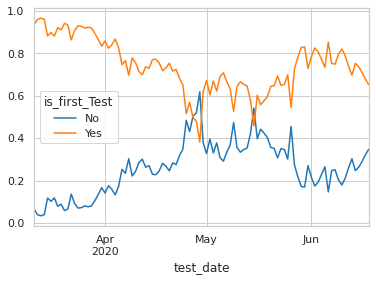

In [ ]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

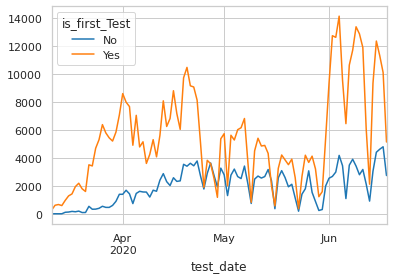

In [ ]:
ti.plot()

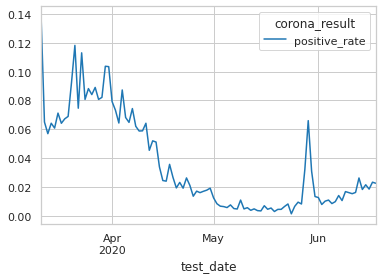

In [ ]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']]
 .plot())

In [ ]:
import altair as alt
ti.tail()

is_first_Test,No,Yes
test_date,,
2020-06-14,3065,9352
2020-06-15,4422,12367
2020-06-16,4636,11325
2020-06-17,4813,10116
2020-06-18,2756,5152


In [ ]:
ti.Yes.sum() + ti.No.sum()

745320

In [ ]:
alt.Chart(ti.reset_index().assign(total=lambda x: x.Yes+x.No)).mark_line().encode(
    x='test_date',
    y='Yes',
    tooltip=['test_date', 'Yes']
).interactive()

alt.Chart(...)

In [ ]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']])

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [ ]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'מונשמים': 'resp'}
hos = (pd.read_csv('https://github.com/cjer/covid/raw/master/data/corona_hospitalization_ver_0011.csv.gz', encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

,date,מאושפזים,אחוז נשים מאושפזות,גיל ממוצע מאושפזים,סטיית תקן גיל מאושפזים,resp,אחוז נשים מונשמות,גיל ממוצע מונשמים,סטיית תקן גיל מונשמים,חולים קל,אחוז נשים חולות קל,גיל ממוצע חולים קל,סטיית תקן גיל חולים קל,חולים בינוני,אחוז נשים חולות בינוני,גיל ממוצע חולים בינוני,סטיית תקן גיל חולים בינוני,critical,אחוז נשים חולות קשה,גיל ממוצע חולים קשה,סטיית תקן גיל חולים קשה
0,2020-03-11,78,35.9,48.0,18.2,15,33.3,68.0,18.2,70,35.7,46.0,16.9,NaN,NaN,NaN,NaN,15,42.9,71.0,17.7
1,2020-03-12,100,39.0,50.0,18.6,15,33.3,68.0,18.2,92,39.1,48.0,17.8,NaN,NaN,NaN,NaN,15,42.9,71.0,17.7
2,2020-03-13,120,39.2,49.0,18.4,15,33.3,68.0,18.2,109,38.5,47.0,17.4,<15,50.0,64.0,17.3,15,42.9,71.0,17.7
3,2020-03-14,158,41.1,47.0,18.5,15,25.0,76.0,12.8,148,41.2,45.0,17.4,<15,50.0,64.0,17.3,15,33.3,79.0,11.4
4,2020-03-15,198,44.9,46.0,18.8,15,33.3,77.0,10.3,183,44.8,44.0,17.5,<15,50.0,58.0,14.9,15,44.4,80.0,9.7


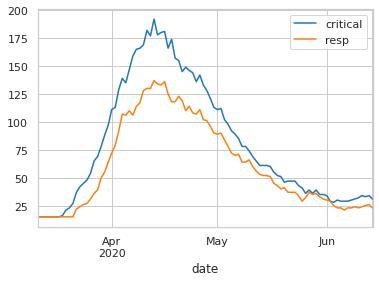

In [ ]:
(hos[['date', 'critical', 'resp']].set_index('date').plot())